In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import operator

import os
import sys
sys.path.append("../src") if "../src" not in sys.path else None 

# custom imports
from methods import *
from GenericDNN import GenericDNN
from swag import *
from evaluation import * 

### Initialize Data and Model

In [3]:
# choose dataset to use
dataset_name = 'energy_heating_load.txt'#'yacht.txt'
datasets_path = '../datasets/'
dataset_path = datasets_path + dataset_name

# load data and create torch training data loader
(X_train, y_train), (X_test, y_test) = load_data(dataset_path)
trainloader = torch.utils.data.DataLoader(Dataset(X_train, y_train, dataset_name.split('.')[0]), 
                                         batch_size:=32, shuffle:=True)

# init model, criterion and optimizer
net = GenericDNN(input_size:=X_train.shape[-1], hidden_size:=input_size, output_size:=1)
criterion = torch.nn.MSELoss()#L1Loss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

### Choose whether to train weights (SWAG), and do inference

In [4]:
# Set 'train:=True' if model not previously trained, or want to train a new model
checkpoint_path = '../checkpoints/'
if train:=False:
    # delete previous checkpoints for model with current dataset
    onlyfiles = [f for f in os.listdir(checkpoint_path) if os.path.isfile(os.path.join(checkpoint_path, f))]
    for file in onlyfiles:
        if trainloader.dataset.name in file:
            print(f"Deletes {file=}")
            os.remove(checkpoint_path + file)
    
    # train and save weights
    train_swag(
        net,
        trainloader,
        optimizer,
        criterion,
        init_epochs=1000,
        sampling_epochs=5,
        nsamples=200,
        path_to_checkpoints="../checkpoints/",
    )

# Do inference (infer approximate sample mean and covariance of an assumed Guassian posterior)
theta_SWA, cov_diag, D = inference_swag(trainloader.dataset.name, checkpoint_path)

### Do predictions

In [5]:
# Do predictions
Lpi, Upi, mu_swa, mu_pred = monte_carlo_PI(trainloader.dataset[:][0], net, theta_SWA, cov_diag, 
                                            D, nsamples=50, percentile=0.9)

# invert prediction normalization
invert_normalization = lambda y: y * trainloader.dataset.stdy + trainloader.dataset.muy
Lpi, Upi, mu_swa, mu_pred = map(invert_normalization, (Lpi, Upi, mu_swa, mu_pred))

# get non-normalized y_true
trainloader.dataset.normalize = False
y_true = trainloader.dataset[:][1]
trainloader.dataset.normalize = True

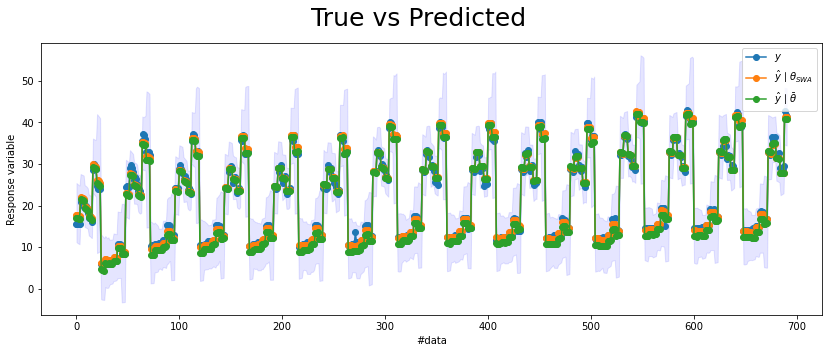

In [6]:
# plotting
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(y_true, "-o", label="$y$")
ax.plot(mu_swa[:,0], "-o", label="$\\hat{y} \\mid \\theta_{SWA}$")
ax.plot(mu_pred[:,0], "-o", label="$\\hat{y} \\mid \\bar{\\theta}$")
ax.set_xlabel("#data")
ax.set_ylabel("Response variable")
ax.legend()
fig.suptitle("True vs Predicted", size=25)
ax.fill_between(np.arange(len(y_train)), Lpi[:,0], Upi[:,0], color='b', alpha=.1)

In [7]:
# evaluate model
print(f"{rmse(y_true, mu_swa)=}, {picp(Lpi, Upi, y_true)=}, {mpiw(Lpi, Upi)=}")

rmse(y_true, mu_swa)=0.72729194, picp(Lpi, Upi, y_true)=1.0, mpiw(Lpi, Upi)=14.513272


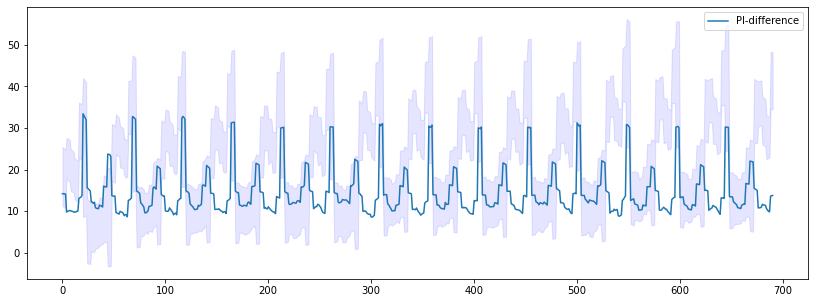

In [8]:
# Plot uncertainty curve and PI difference
# - We expect the PI to be wider where there is few data points, i.e. at the peaks of the "yatch.txt" 
# dataset, but the plot above does not seem to support this fact. However, when the graph "grows"
# quickly, the PI width appears thin, while it in reality is actually wider. 
# This can be seen from the follow plot: I.e. that the PI difference grows near the peaks, and
# becomes smaller near the troughs.
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(Upi[:,0] - Lpi[:,0], label='PI-difference')
ax.fill_between(np.arange(len(y_train)), Lpi[:,0], Upi[:,0], color='b', alpha=.1)
ax.legend()